In [ ]:
! git clone https://github.com/aosokin/os2d.git

Cloning into 'os2d'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 206 (delta 76), reused 183 (delta 55), pack-reused 0
Receiving objects: 100% (206/206), 1.33 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
cd os2d

/content/os2d


In [ ]:
pip install yacs

In [ ]:
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio

logger = setup_logger("OS2D")

In [ ]:
cfg.is_cuda = torch.cuda.is_available()

In [ ]:
!./os2d/utils/wget_gdrive.sh models/os2d_v2-train.pth 1l_aanrxHj14d_QkCpein8wFmainNAzo8

--2021-10-18 12:06:25--  https://docs.google.com/uc?export=download&confirm=&id=1l_aanrxHj14d_QkCpein8wFmainNAzo8
Resolving docs.google.com (docs.google.com)... 173.194.210.138, 173.194.210.101, 173.194.210.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.210.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-0s-docs.googleusercontent.com/docs/securesc/u5ncdsgrag3qvkt2pvch93mvu9eif1d4/phpk44a8d2brv6f6lhav123f2d8i9lg0/1634558775000/02695332612409210478/03032875465225645650Z/1l_aanrxHj14d_QkCpein8wFmainNAzo8?e=download [following]
--2021-10-18 12:06:26--  https://doc-0s-0s-docs.googleusercontent.com/docs/securesc/u5ncdsgrag3qvkt2pvch93mvu9eif1d4/phpk44a8d2brv6f6lhav123f2d8i9lg0/1634558775000/02695332612409210478/03032875465225645650Z/1l_aanrxHj14d_QkCpein8wFmainNAzo8?e=download
Resolving doc-0s-0s-docs.googleusercontent.com (doc-0s-0s-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting

In [ ]:
cfg.init.model = "models/os2d_v2-train.pth"
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

2021-10-18 12:06:31,620 OS2D INFO: Building the OS2D model
2021-10-18 12:06:32,263 OS2D INFO: Creating model on CPU
2021-10-18 12:06:32,265 OS2D INFO: Reading model file models/os2d_v2-train.pth
2021-10-18 12:06:32,361 OS2D INFO: Loaded complete model from checkpoint
2021-10-18 12:06:32,364 OS2D INFO: Cannot find 'optimizer' in the checkpoint file. Initializing optimizer from scratch.
2021-10-18 12:06:32,372 OS2D INFO: OS2D has 139 blocks of 10169478 parameters (before freezing)
2021-10-18 12:06:32,384 OS2D INFO: OS2D has 139 blocks of 10169478 trainable parameters


In [ ]:
input_image = read_image("data/demo/input_image.jpg")
class_images = [read_image("data/demo/class_image_0.jpg"), read_image("data/demo/class_image_1.jpg") ]
class_ids = [0 , 1]

In [ ]:
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

In [ ]:
h, w = get_image_size_after_resize_preserving_aspect_ratio(h=input_image.size[1],
                                                               w=input_image.size[0],
                                                               target_size=1500)
input_image = input_image.resize((w, h))

input_image_th = transform_image(input_image)
input_image_th = input_image_th.unsqueeze(0)
if cfg.is_cuda:
    input_image_th = input_image_th.cuda()

In [ ]:
class_images_th = []
for class_image in class_images:
    h, w = get_image_size_after_resize_preserving_aspect_ratio(h=class_image.size[1],
                                                               w=class_image.size[0],
                                                               target_size=cfg.model.class_image_size)
    class_image = class_image.resize((w, h))

    class_image_th = transform_image(class_image)
    if cfg.is_cuda:
        class_image_th = class_image_th.cuda()

    class_images_th.append(class_image_th)

In [ ]:
with torch.no_grad():
     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(images=input_image_th, class_images=class_images_th)

print(loc_prediction_batch)

tensor([[[[-1.2186, -0.5464, -0.6098,  ..., -1.2497, -0.5627,  0.1150],
          [-0.7625, -0.9958, -0.9052,  ..., -0.6691, -0.3368,  0.1378],
          [ 3.7702,  2.0625,  1.9732,  ...,  3.1737,  2.3429,  1.9929],
          [ 3.6214,  3.1611,  2.6790,  ...,  2.7380,  2.9915,  2.9396]],

         [[-1.1311, -0.5055, -0.5992,  ..., -1.6207, -0.7017,  0.2312],
          [-0.7824, -1.0268, -0.9212,  ..., -0.6666, -0.4025,  0.1088],
          [ 3.6524,  1.9468,  1.5320,  ...,  3.8245,  3.0985,  2.2646],
          [ 3.7716,  3.4050,  2.9523,  ...,  2.6623,  2.9146,  2.9370]]]])


In [ ]:
image_loc_scores_pyramid = [loc_prediction_batch[0]]
image_class_scores_pyramid = [class_prediction_batch[0]]
img_size_pyramid = [FeatureMapSize(img=input_image_th)]
transform_corners_pyramid = [transform_corners_batch[0]]

In [ ]:

boxes = box_coder.decode_pyramid(image_loc_scores_pyramid, image_class_scores_pyramid,
                                           img_size_pyramid, class_ids,
                                           nms_iou_threshold=cfg.eval.nms_iou_threshold,
                                           nms_score_threshold=cfg.eval.nms_score_threshold,
                                           transform_corners_pyramid=transform_corners_pyramid)

# remove some fields to lighten visualization                                       
boxes.remove_field("default_boxes")

In [ ]:
scores = boxes.get_field("scores")
print(scores)

tensor([0.5660, 0.5585, 0.5540, 0.5387, 0.5216, 0.5124, 0.5122, 0.5019, 0.4910,
        0.4820, 0.4658, 0.4402, 0.4387, 0.4340, 0.4228, 0.4227, 0.4224, 0.4215,
        0.4204, 0.4125, 0.4101, 0.4073, 0.4073, 0.4064, 0.4026, 0.3977, 0.3952,
        0.3929, 0.3900, 0.3821, 0.3796, 0.3785, 0.3780, 0.3763, 0.3752, 0.3718,
        0.3709, 0.3709, 0.3708, 0.3683, 0.3644, 0.3586, 0.3570, 0.3565, 0.3527,
        0.3511, 0.3499, 0.3488, 0.3480, 0.3478, 0.3458, 0.3449, 0.3441, 0.3423,
        0.3417, 0.3408, 0.3378, 0.3290, 0.3280, 0.3267, 0.3264, 0.3256, 0.3256,
        0.3187, 0.3171, 0.3116, 0.3037, 0.3034, 0.3028, 0.2944, 0.2943, 0.2933,
        0.2913, 0.2765, 0.2713, 0.5603, 0.5556, 0.5471, 0.5090, 0.5083, 0.5059,
        0.4965, 0.4952, 0.4868, 0.4764, 0.4715, 0.4548, 0.4515, 0.4429, 0.4415,
        0.4090, 0.4082, 0.4048, 0.4035, 0.3900, 0.3874, 0.3839, 0.3777, 0.3772,
        0.3740, 0.3675, 0.3667, 0.3664, 0.3640, 0.3632, 0.3631, 0.3627, 0.3622,
        0.3590, 0.3571, 0.3564, 0.3535, 

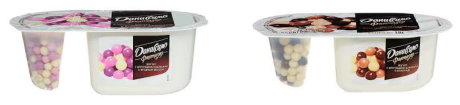

In [ ]:
figsize = (8, 8)
fig=plt.figure(figsize=figsize)
columns = len(class_images)
for i, class_image in enumerate(class_images):
    fig.add_subplot(1, columns, i + 1)
    plt.imshow(class_image)
    plt.axis('off')

BoxList(num_boxes=1, image_width=1743, image_height=1290, )


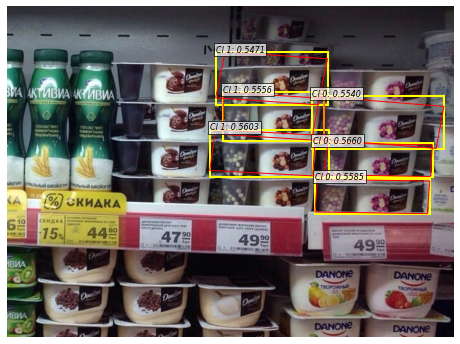

In [ ]:

plt.rcParams["figure.figsize"] = figsize

cfg.visualization.eval.max_detections = 6
cfg.visualization.eval.score_threshold = float("-inf")
print(boxes[1])
visualizer.show_detections(boxes, input_image,
                           cfg.visualization.eval)